## Problem Statement 

Typically a house in Manhattan comprises of various electrical appliances. Each of these appliances partly contributes to the total energy consumption of the house. If these houses are grouped based on their power usage, it helps to analyze the requirement of electric power in different parts of the city. Also, the insights can be useful to identify the appliances with high and low usage of electricity. In this case study, we consider the power consumption due to various appliances in the house and try to group the houses as per their power consumption.

##  Data Definition 

The dataset represents the electric power consumption in the house. The data definition is as follows:

**Global_active_power**: The global minute-averaged active power of the house (in KW)

**Global_reactive_power**: The global minute-averaged reactive power of the house (in KW)

**Voltage**: The minute-averaged voltage of the house (in volt)

**Global_intensity**: The global minute-averaged current intensity of the house (in ampere)

**Kitchen_consumption**: The power consumption of the appliances in the kitchen (in watt-hour)

**Laundry_consumption**: The power consumption of the appliances in the laundry room (in watt-hour)

**Other_appliances_consumption**: The power consumption of the appliances other than in the kitchen and laundry room (in watt-hour)

<a id='import_lib'></a>
# 1. Import Libraries

In [1]:
# suppress display of warnings
import warnings
warnings.filterwarnings("ignore")


import pandas as pd 


import numpy as np


import matplotlib.pyplot as plt


import seaborn as sns


np.set_printoptions(suppress=True)


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances

# import functions from scipy to plot the dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram


from sklearn.decomposition import PCA

In [2]:
 
plt.rcParams['figure.figsize'] = [15,8]

In [3]:

df_power = pd.read_excel('power.xlsx')


df_power.head()



,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption
0,2.242,0.162,237.33,10.0,1,7,17
1,3.714,0.296,235.15,15.8,2,35,17
2,3.212,0.304,235.99,14.2,1,26,17
3,3.694,0.280,235.16,15.6,1,35,17
4,3.204,0.292,236.08,14.0,1,27,17


#### Dimensions of the data

In [4]:
df_power.shape

(21240, 7)

In [5]:

df_power.dtypes

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Kitchen_consumption               int64
Laundry_consumption               int64
Other_appliances_consumption      int64
dtype: object

#### All the variables have the data type as per the data definition. Thus, there is no need for type 

As all the variables are numerical, we plot the boxplot for each variable to check the distribution. Also, we can use these boxplots to identify the outliers in the variables.

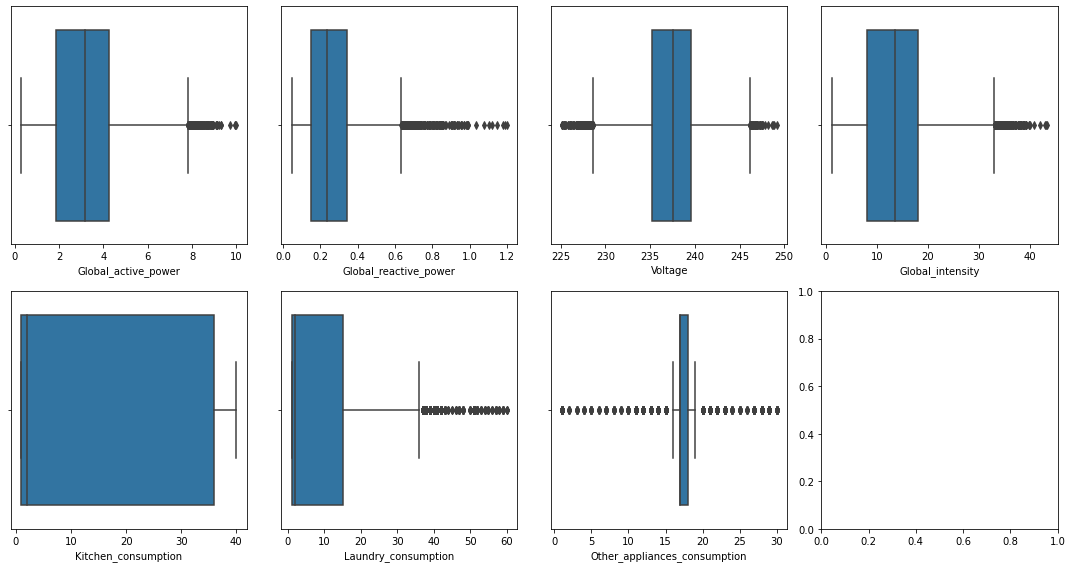

In [6]:

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(15, 8))


for variable, subplot in zip(df_power.columns, ax.flatten()):   
    
    
    sns.boxplot(df_power[variable], ax = subplot)


plt.tight_layout()


plt.show()

#### The above boxplots show that the variable 'Voltage' is near normally distributed, and the variable 'Other_appliances_consumption' is negatively distributed. All the remaining variables are positively distributed. <br><br> Also, it can be easily seen that all the variables except 'Kitchen_consumption' have outliers



The data distribution in the previous section exhibits the presence of outliers in the data. Now let us use the IQR method to remove these observations and plot the boxplots to recheck the presence of outliers.

In [7]:

Q1 = df_power.quantile(0.25)

Q3 = df_power.quantile(0.75)


IQR = Q3 - Q1

df_power = df_power[~((df_power < (Q1 - 1.5 * IQR)) | (df_power > (Q3 + 1.5 * IQR))).any(axis=1)]

df_power = df_power.reset_index(drop = True)

To confirm that the outliers have been removed; let us visualize the boxplot again.

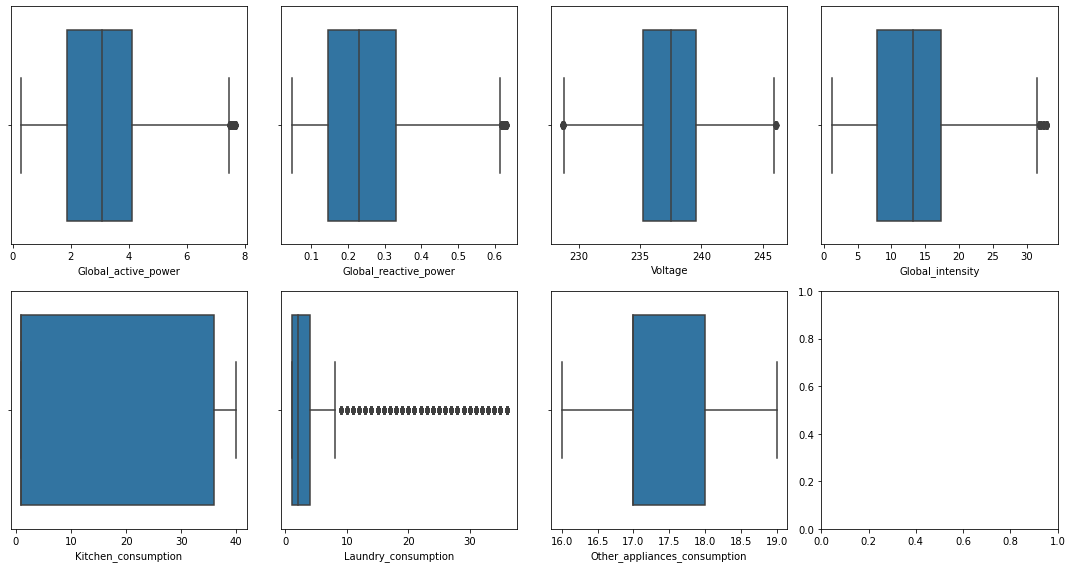

In [8]:

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(15, 8))


for variable, subplot in zip(df_power.columns, ax.flatten()):   
    
   
    sns.boxplot(df_power[variable], ax = subplot)


plt.tight_layout()


plt.show()

Observing the range of the boxplots, we say that the outliers are removed from the original data. The new 'outliers' that we can see in the variables are moderate outliers that lied within the upper whisker-lower whisker range before removing the original outliers. It can be seen that the variable `Other_appliances_consumption` has no new outliers.

It is up to the discretion of the data scientist, to remove them or not; and maybe decided after evaluating the model performance. 

A crude way to know whether the outliers have been removed or not is to check the dimensions of the data. If the dimension is reduced it implies that the outliers are removed.

In [9]:
# checking the shape of the data after removal of outliers 
df_power.shape

(16724, 7)

In [10]:
# the describe() returns the statistical summary of the variables
# by default, it returns the summary of numerical variables
df_power.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption
count,16724.000000,16724.000000,16724.000000,16724.000000,16724.000000,16724.000000,16724.000000
mean,3.197480,0.249404,237.351591,13.601495,13.151937,6.802141,17.428426
std,1.444141,0.132148,3.289317,6.204866,16.384600,10.920451,0.705236
min,0.302000,0.046000,228.600000,1.200000,1.000000,1.000000,16.000000
25%,1.858000,0.144000,235.220000,7.800000,1.000000,1.000000,17.000000
50%,3.096000,0.230000,237.510000,13.200000,1.000000,2.000000,17.000000
75%,4.100000,0.332000,239.520000,17.400000,36.000000,4.000000,18.000000
max,7.716000,0.632000,246.150000,33.000000,40.000000,36.000000,19.000000


#### The average active power for the house is 3.19 KW. Whereas the average current intensity is 13.6 ampere. The consumption of other appliances is 16-19 watt-hours of active energy

Let us plot the heatmap to visualize the missing values in the data.

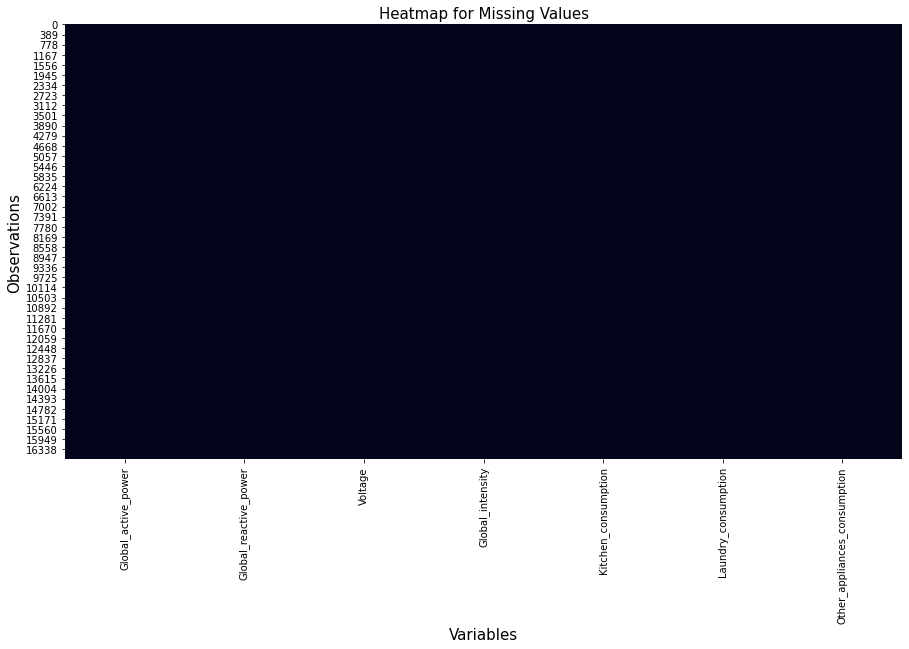

In [11]:

sns.heatmap(df_power.isnull(), cbar=False)


plt.title('Heatmap for Missing Values', fontsize = 15)
plt.xlabel('Variables', fontsize = 15)
plt.ylabel('Observations', fontsize = 15)


plt.show()

**Scale the data**

Here let us use the z-score normalization (i.e. standardization) technique to scale the dataset. In the scaled data, each variable will have a mean 0 and a standard deviation of 1.

In [12]:
# create a copy of the original dataset 
features = df_power.copy()

# head() to display top five rows
features.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption
0,2.242,0.162,237.33,10.0,1,7,17
1,3.714,0.296,235.15,15.8,2,35,17
2,3.212,0.304,235.99,14.2,1,26,17
3,3.694,0.280,235.16,15.6,1,35,17
4,3.204,0.292,236.08,14.0,1,27,17


In [13]:

scaler = StandardScaler()


features = scaler.fit_transform(features)     


features_scaled = pd.DataFrame(features, columns = df_power.columns)
                               

features_scaled.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption
0,-0.661645,-0.661430,-0.006564,-0.580448,-0.741690,0.018119,-0.607511
1,0.357676,0.352612,-0.669335,0.354330,-0.680656,2.582192,-0.607511
2,0.010054,0.413151,-0.413956,0.096460,-0.741690,1.758026,-0.607511
3,0.343827,0.231532,-0.666295,0.322096,-0.741690,2.582192,-0.607511
4,0.004515,0.322342,-0.386593,0.064227,-0.741690,1.849600,-0.607511



# K-means Clustering

K-means is the most widely-used centroid-based clustering algorithm. In this method, we need to prespecify the number of clusters to the algorithm. This method tends to build more circular clusters.

Let us first identify the optimal number of clusters and analyze the obtained clusters.


#### Identifying the Optimal Number of Clusters
#### Plotting the elbow plot and identify the optimal number of clusters. Also, using the silhouette score method to validate the optimal number of clusters.

We do not know how many clusters give the most useful results. So, we create the clusters with varying K, from 1 to 7 and then decide the optimum number of clusters (K) with the help of the elbow plot.

In [14]:

wcss  = []

for i in range(1,8):
    kmeans = KMeans(n_clusters = i, random_state = 10)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

Let us plot the elbow plot and identify the elbow point.

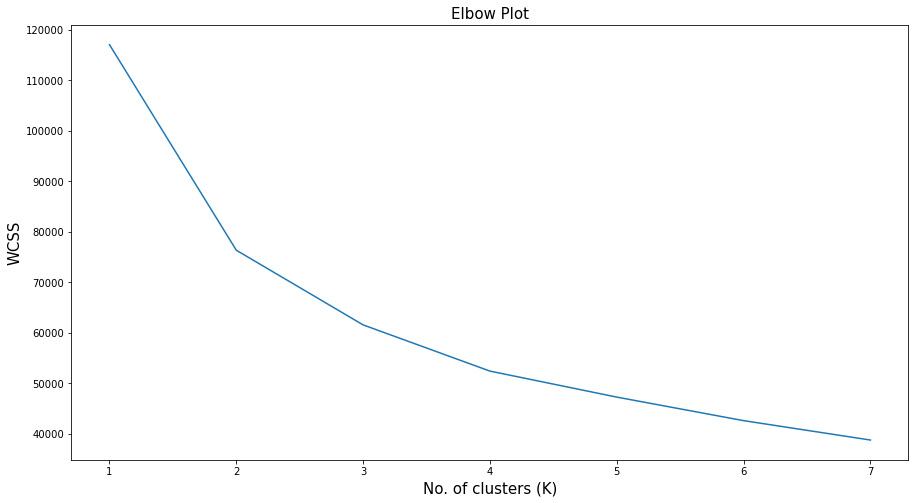

In [15]:

plt.plot(range(1,8), wcss)


plt.title('Elbow Plot', fontsize = 15)
plt.xlabel('No. of clusters (K)', fontsize = 15)
plt.ylabel('WCSS', fontsize = 15)


plt.show()

From the above plot, we can consider the K = 2 or 3 as the optimal number of clusters; as after these values, the WCSS is not decreasing rapidly.

Since the elbow point is not clearly visible, we can also use the `KneeLocator()` from the 'kneed' library in python. This function returns the point of maximum curvature (i.e. elbow/knee point).

In [16]:
 
from kneed.knee_locator import KneeLocator


k = KneeLocator(x  = range(1,8), y = wcss, curve = 'convex', direction = 'decreasing')


k.elbow

3

The python in-built elbow locator function returns K = 3 as the optimal value for the number of clusters.

Use the silhouette score method to validate the optimal number of clusters

Let us find the silhouette score with different values of K from 2 to 7. We consider the optimal value of K for which the silhouette score is maximum.



In [17]:

n_clusters = [2, 3, 4, 5, 6, 7]


for K in n_clusters :
    cluster = KMeans (n_clusters = K, random_state = 10)
    predict = cluster.fit_predict(features_scaled)
    
    
    score = silhouette_score(features_scaled, predict, random_state= 10)
    print ("For n_clusters = {}, silhouette score is {})".format(K, score))

For n_clusters = 2, silhouette score is 0.32850947743246767)
For n_clusters = 3, silhouette score is 0.34162061321967313)
For n_clusters = 4, silhouette score is 0.27827300157898077)
For n_clusters = 5, silhouette score is 0.28724123736988394)
For n_clusters = 6, silhouette score is 0.27429169437265116)
For n_clusters = 7, silhouette score is 0.2636600472800798)


From the above output it can be seen that, for K = 3, the score is the highest.
From the elbow plot and silhouette score method, we can consider the optimal number of clusters as 3. 
Now let us group the dataset into 3 clusters.

Let us group the dataset into 3 clusters and check the number of elements in each cluster.

In [18]:

K_model = KMeans(n_clusters= 3, random_state= 10)


K_model.fit(features_scaled)

KMeans(n_clusters=3, random_state=10)

In [19]:
df_power['Kmeans_label'] = K_model.labels_

df_power.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label
0,2.242,0.162,237.33,10.0,1,7,17,1
1,3.714,0.296,235.15,15.8,2,35,17,0
2,3.212,0.304,235.99,14.2,1,26,17,0
3,3.694,0.280,235.16,15.6,1,35,17,0
4,3.204,0.292,236.08,14.0,1,27,17,0


The new column of cluster label added to the dataframe that indicates the cluster number for each observation.

#### Checking the size of each cluster

In [20]:

np.unique(K_model.labels_, return_counts=True)                

(array([0, 1, 2]), array([2631, 9041, 5052], dtype=int64))

We have formed three clusters, where there are 9041 observartions in one cluster, and 5052 and 2631 observations in the other two clusters

#### Plot a barplot to visualize the cluster sizes. 

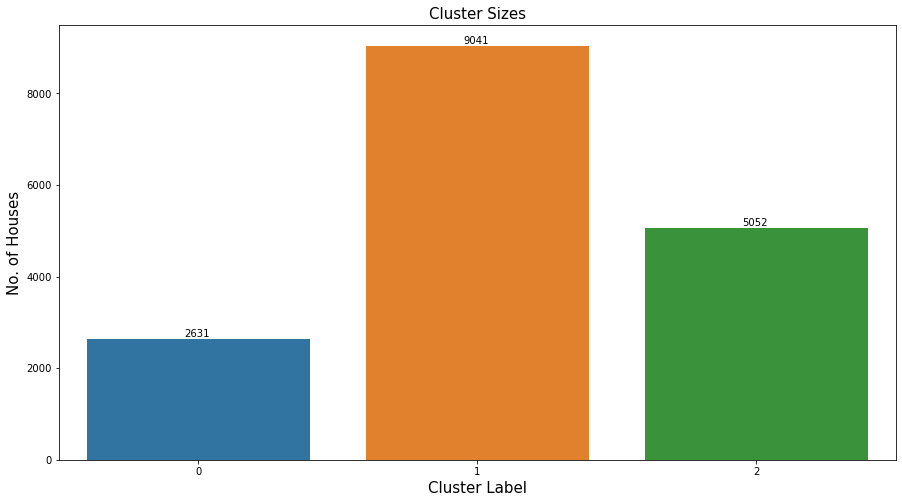

In [21]:

sns.countplot(data= df_power, x = 'Kmeans_label')


plt.title('Cluster Sizes', fontsize = 15)
plt.xlabel('Cluster Label', fontsize = 15)
plt.ylabel('No. of Houses', fontsize = 15)


plt.text(x = -0.05, y = np.unique(K_model.labels_, return_counts=True)[1][0] + 50, 
         s = np.unique(K_model.labels_, return_counts=True)[1][0])

plt.text(x = 0.95, y = np.unique(K_model.labels_, return_counts=True)[1][1] + 50, 
         s = np.unique(K_model.labels_, return_counts=True)[1][1])

plt.text(x = 1.95, y = np.unique(K_model.labels_, return_counts=True)[1][2] + 50, 
         s = np.unique(K_model.labels_, return_counts=True)[1][2])


plt.show()

In [ ]:
## Finding centre of cluster

In [22]:

centers = pd.DataFrame(K_model.cluster_centers_, columns =  (df_power.drop('Kmeans_label', axis=1)).columns)      

# displaying the cluster centers
centers

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption
0,1.181832,-0.029629,-0.690051,1.195042,-0.018069,2.120979,-0.546585
1,-0.752184,-0.074388,0.438037,-0.752308,-0.692644,-0.376352,0.323242
2,0.731003,0.148562,-0.424762,0.724348,1.249091,-0.430561,-0.293989


The above cluster centers are corresponding to the scaled data. Now let us obtain the centers for the original data. This will be helpful to analyze the clusters in terms of the business case.

In [23]:

unscaled_centers = pd.DataFrame(scaler.inverse_transform(K_model.cluster_centers_), 
                                columns =  (df_power.drop('Kmeans_label', axis=1)).columns)      

# displaying the dataframe
unscaled_centers

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption
0,4.904161,0.245489,235.081863,21.016350,12.855894,29.963498,17.042966
1,2.111254,0.239574,238.792390,8.933665,1.803583,2.692325,17.656381
2,4.253120,0.269036,235.954456,18.095843,33.617181,2.100356,17.221101


**Computing the statistical summary of the observations in the 1st cluster.**

In [24]:

df_power[df_power.Kmeans_label == 0].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label
count,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000,2631.000000,2631.0
mean,4.903595,0.245615,235.083641,21.014139,12.851387,29.961612,17.043330,0.0
std,1.265566,0.134463,3.032361,5.432208,16.057370,5.831054,0.646447,0.0
min,2.404000,0.046000,228.600000,10.600000,1.000000,5.000000,16.000000,0.0
25%,3.766000,0.134000,232.830000,16.000000,1.000000,26.000000,17.000000,0.0
50%,4.896000,0.228000,235.120000,21.000000,1.000000,31.000000,17.000000,0.0
75%,5.868000,0.328000,237.150000,25.100000,36.000000,35.000000,17.000000,0.0
max,7.716000,0.626000,245.050000,33.000000,40.000000,36.000000,19.000000,0.0


There are 2631 houses in this cluster, which makes this the smallest cluster. Here the houses that have the highest average consumption of the laundry room appliances are grouped. We can see that 50% of the houses have kitchen appliances that consume only 1 watt-hour power. The global active power is between 2.4 to 7.7 KW. On average, the other appliances in the houses are consuming 17 watt-hours of power. The average intensity of the current is the highest for the houses in this cluster.

**Computing the statistical summary of the observations in the 2nd cluster.**

In [25]:

df_power[df_power.Kmeans_label == 1].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label
count,9041.000000,9041.000000,9041.000000,9041.000000,9041.000000,9041.000000,9041.000000,9041.0
mean,2.111110,0.239537,238.792283,8.932972,1.803672,2.689857,17.656343,1.0
std,0.666134,0.124966,2.841568,2.852534,2.909028,4.556848,0.658442,0.0
min,0.302000,0.046000,228.950000,1.200000,1.000000,1.000000,16.000000,1.0
25%,1.568000,0.138000,237.050000,6.600000,1.000000,1.000000,17.000000,1.0
50%,1.928000,0.222000,238.810000,8.200000,1.000000,1.000000,18.000000,1.0
75%,2.590000,0.316000,240.650000,11.000000,1.000000,2.000000,18.000000,1.0
max,5.100000,0.632000,246.150000,21.400000,30.000000,33.000000,19.000000,1.0


There are 9041 houses in this cluster, which makes this the largest cluster. Here the houses that have the highest average consumption of appliances other than the kitchen and laundry room are grouped. We can see that 50% of the houses have only 1 watt-hour power consumption in the kitchen and the laundry room. The global active power is between 0.3 to 5.1 KW, which is less than the other clusters. The average intensity of the current is the lowest for these houses.

**Computing the statistical summary of the observations in the 3rd cluster.**

In [26]:

df_power[df_power.Kmeans_label == 2].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label
count,5052.000000,5052.000000,5052.000000,5052.000000,5052.000000,5052.000000,5052.000000,5052.0
mean,4.253120,0.269036,235.954456,18.095843,33.617181,2.100356,17.221101,2.0
std,0.730371,0.141021,2.869831,3.115066,9.483615,2.864460,0.663264,0.0
min,2.170000,0.046000,228.620000,10.200000,1.000000,1.000000,16.000000,2.0
25%,3.731500,0.162000,234.130000,15.800000,36.000000,1.000000,17.000000,2.0
50%,4.065000,0.252000,236.160000,17.200000,37.000000,1.000000,17.000000,2.0
75%,4.684500,0.368000,237.860000,20.000000,38.000000,2.000000,18.000000,2.0
max,7.698000,0.632000,245.010000,32.800000,40.000000,22.000000,19.000000,2.0


There are 5052 houses in this cluster. Here the houses that have the highest average consumption of kitchen appliances are grouped. We can see that 50% of the houses have laundry room appliances that consume 1 watt-hour power. The global active power is between 2.17 to 7.69 KW. The average intensity of the current is 18 ampere for these houses.

# Hierarchical Clustering

Building a dendrogram to identify the optimal number of clusters.

**Let us first calculate the linkage matrix.**



In [27]:

link_mat = linkage(features_scaled, method = 'ward')     

print(link_mat[0:10])

[[ 5946.          5947.             0.00138495     2.        ]
 [13128.         13129.             0.00138495     2.        ]
 [13905.         13908.             0.00138495     2.        ]
 [12811.         12813.             0.0027699      2.        ]
 [ 1057.          1060.             0.00304024     2.        ]
 [ 7058.          7062.             0.00304024     2.        ]
 [ 5164.          5167.             0.00304024     2.        ]
 [ 6752.          6753.             0.00304024     2.        ]
 [12130.         12132.             0.00304024     2.        ]
 [ 8754.          8757.             0.00304024     2.        ]]


**Plot the dendrogram using the above linkage matrix.**

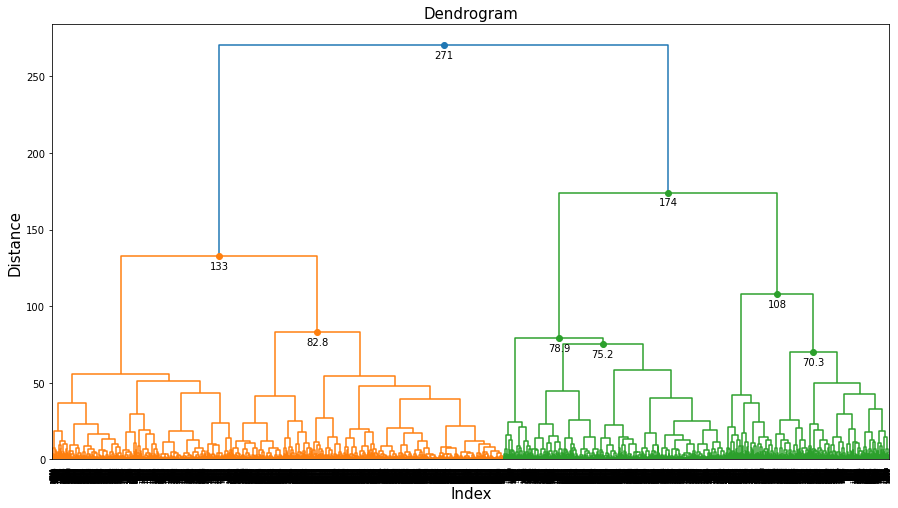

In [28]:

dendro = dendrogram(link_mat)


for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    
    
    x = sum(i[1:3])/2
    
    
    y = d[1]
    
    
    if y > 60:
        
        
        plt.plot(x, y, 'o', c=c)
        
        
        plt.annotate("%.3g" % y, (x, y), xytext=(0, -5), textcoords='offset points', va='top', ha='center')


plt.title('Dendrogram', fontsize = 15)
plt.xlabel('Index', fontsize = 15)
plt.ylabel('Distance', fontsize = 15)


plt.show()

The above dendrogram shows that the number of clusters (=2) is constant from the distance 174 to 271. Thus, the dendrogram returns the value 'two' as the optimal number of clusters. But the two clusters will only provide the group of houses with 'high' or 'low' power consumption. To group the houses based on the power consumption in different parts of the house, we need to group the data into more than 2 clusters.

We can group the dataset into 3 or 4 clusters to gain more insights from the data. We can also use the silhouette method to identify the optimal number of clusters, as we did for the K-means clustering. 

Let us plot the silhouette score for different values of K. The `K` with the highest Silhouette score represents the optimal value for the number of clusters (K).

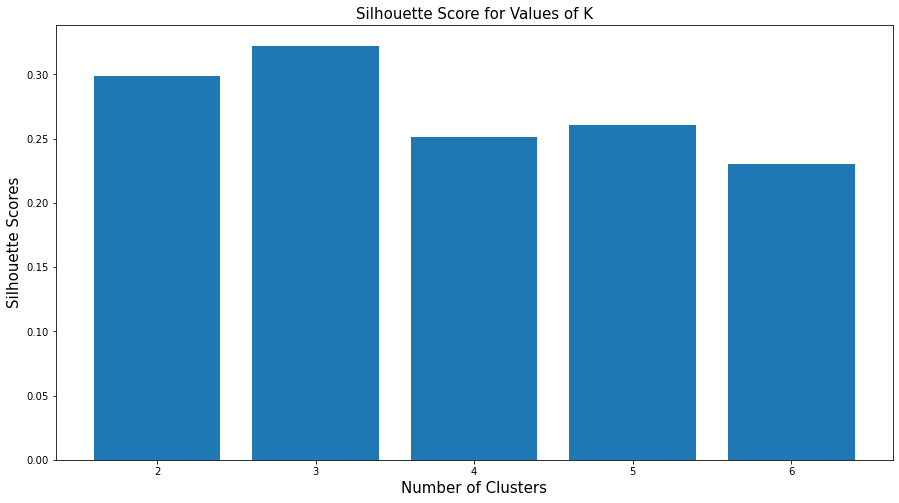

In [29]:

K = [2, 3, 4, 5, 6]

silhouette_scores = [] 


for i in K:
    
 
    hierar_model = AgglomerativeClustering(n_clusters = i, linkage = 'ward') 
    
    
    silhouette_scores.append(silhouette_score(features_scaled, hierar_model.fit_predict(features_scaled))) 
    

plt.bar(K, silhouette_scores) 


plt.title('Silhouette Score for Values of K', fontsize = 15)
plt.xlabel('Number of Clusters', fontsize = 15) 
plt.ylabel('Silhouette Scores', fontsize = 15)


plt.show()

Now let us group the dataset into 3 clusters and analyze them.

In [30]:

hierar_clusters = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')


hierar_clusters.fit(features_scaled)

AgglomerativeClustering(n_clusters=3)

In [31]:

df_power['Hierar_label'] = hierar_clusters.labels_


df_power.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label,Hierar_label
0,2.242,0.162,237.33,10.0,1,7,17,1,0
1,3.714,0.296,235.15,15.8,2,35,17,0,1
2,3.212,0.304,235.99,14.2,1,26,17,0,1
3,3.694,0.280,235.16,15.6,1,35,17,0,1
4,3.204,0.292,236.08,14.0,1,27,17,0,1


#### Checking the number of houses in each cluster.

In [32]:

df_power['Hierar_label'].value_counts()

0    9025
2    4431
1    3268
Name: Hierar_label, dtype: int64

The largest cluster contains 9025 observations and the smallest cluster is the one containing 3268 houses.

### Let us analyze and interpret the clusters formed by hierarchical clustering.

**Computing the statistical summary of the observations in the 1st cluster.**

In [33]:

df_power[df_power.Hierar_label == 0].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label,Hierar_label
count,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.000000,9025.0
mean,2.169233,0.243884,238.507899,9.200953,2.204211,1.655180,17.604765,1.054183,0.0
std,0.781089,0.127607,2.974284,3.385530,3.950164,1.331098,0.677592,0.234564,0.0
min,0.302000,0.046000,228.950000,1.200000,1.000000,1.000000,16.000000,0.000000,0.0
25%,1.568000,0.140000,236.700000,6.600000,1.000000,1.000000,17.000000,1.000000,0.0
50%,1.928000,0.226000,238.580000,8.200000,1.000000,1.000000,18.000000,1.000000,0.0
75%,2.640000,0.322000,240.450000,11.200000,2.000000,2.000000,18.000000,1.000000,0.0
max,6.106000,0.632000,246.120000,26.000000,33.000000,20.000000,19.000000,2.000000,0.0


There are 9025 houses in this cluster, which makes this the largest cluster. Here the houses that have the highest average consumption of appliances other than the kitchen and laundry room are grouped. We can see that 50% of the houses have only 1 watt-hour power consumption in the kitchen and the laundry room. The global active power is between 0.3 to 6.1 KW, which is less than the other clusters. The average intensity of the current is the lowest for these houses. Most of the points in this cluster are grouped into the largest cluster (cluster with label '1') of the K-means clustering.

**Compute the statistical summary of the observations in the 2nd cluster.**

In [34]:

df_power[df_power.Hierar_label == 1].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label,Hierar_label
count,3268.000000,3268.000000,3268.000000,3268.000000,3268.000000,3268.000000,3268.000000,3268.000000,3268.0
mean,4.580390,0.242856,235.935382,19.597858,11.941860,27.849143,17.191554,0.253060,1.0
std,1.370074,0.130985,3.369269,5.894014,15.817746,7.038976,0.681669,0.529428,0.0
min,1.562000,0.046000,228.600000,6.600000,1.000000,8.000000,16.000000,0.000000,1.0
25%,3.422000,0.136000,233.510000,14.600000,1.000000,22.000000,17.000000,0.000000,1.0
50%,4.450000,0.228000,235.950000,19.000000,1.000000,29.000000,17.000000,0.000000,1.0
75%,5.684000,0.316000,238.220000,24.200000,35.000000,35.000000,18.000000,0.000000,1.0
max,7.716000,0.626000,246.150000,33.000000,40.000000,36.000000,19.000000,2.000000,1.0


There are 3268 houses in this cluster, which makes this the smallest cluster. Here the houses that have the highest average consumption of the laundry room appliances are grouped. We can see that 50% of the houses have kitchen appliances that consume only 1 watt-hour power. The global active power is between 1.56 to 7.7 KW. On average, the other appliances in these houses are consuming 17 watt-hours of power. The average intensity of the current is the highest for the houses in this cluster. <br><br> 75% of the observations in this cluster are grouped into the smallest cluster (cluster with label '0') of the K-means clustering.

**Compute the statistical summary of the observations in the 3rd cluster.**

In [35]:

df_power[df_power.Hierar_label == 2].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label,Hierar_label
count,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4431.0
mean,4.271862,0.265478,236.040934,18.141954,36.342586,1.762582,17.243963,1.986910,2.0
std,0.725525,0.140527,2.920575,3.126222,3.731507,1.970335,0.678811,0.154131,0.0
min,2.456000,0.046000,228.620000,11.600000,1.000000,1.000000,16.000000,0.000000,2.0
25%,3.742000,0.160000,234.210000,15.800000,36.000000,1.000000,17.000000,2.000000,2.0
50%,4.068000,0.246000,236.270000,17.200000,37.000000,1.000000,17.000000,2.000000,2.0
75%,4.685000,0.364000,237.965000,19.800000,38.000000,2.000000,18.000000,2.000000,2.0
max,7.698000,0.632000,245.170000,32.800000,40.000000,27.000000,19.000000,2.000000,2.0


There are 4431 houses in this cluster. Here the houses that have the highest average consumption of kitchen appliances are grouped. We can see that 50% of the houses have laundry room appliances that onsume only 1 watt-hour power. The global active power is between 2.45 to 7.69 KW. The average intensity of the current is 18.14 ampere for these houses.

# DBSCAN

In [36]:

dist_array = euclidean_distances(features_scaled)[np.triu_indices(16724, k = 1)]


print('Minimum Distance:', dist_array.min())


print('Maximum Distance:', dist_array.max())

Minimum Distance: 0.001384947609371129
Maximum Distance: 10.179949808197904


The above output shows that the minimum distance between two distinct data points is 0.0013 and the maximum distance is 10.18.

As the distance between the points is in the range 0 to 10, we consider the epsilon as 0.5, and while increasing the epsilon, we get 4 clusters at epsilon = 1.4; after 1.4, we get a single cluster. 

Thus, let us consider the epsilon as 1.4, i.e. a point will be in the neighbourhood of another point if the euclidean distance between them is not more than 1.4. Also, there should be a minimum of 4 points in the neighbourhood of a core point (including itself).

In [37]:

dbscan_model = DBSCAN(eps = 1.4, min_samples = 4)


dbscan_model.fit(features_scaled)

DBSCAN(eps=1.4, min_samples=4)

#### Check the number of clusters formed by DBSCAN.

In [38]:

(set(dbscan_model.labels_))

{-1, 0, 1, 2, 3}

In [39]:

df_power['DBSCSAN_label'] = dbscan_model.labels_


df_power.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label,Hierar_label,DBSCSAN_label
0,2.242,0.162,237.33,10.0,1,7,17,1,0,0
1,3.714,0.296,235.15,15.8,2,35,17,0,1,0
2,3.212,0.304,235.99,14.2,1,26,17,0,1,0
3,3.694,0.280,235.16,15.6,1,35,17,0,1,0
4,3.204,0.292,236.08,14.0,1,27,17,0,1,0


#### Check the number of houses in each cluster.

In [40]:

df_power['DBSCSAN_label'].value_counts()

 0    7559
 2    7048
 1    1367
 3     739
-1      11
Name: DBSCSAN_label, dtype: int64

The largest cluster contains 7559 observations and the smallest cluster is the one containing 739 observations. 11 houses are identified as outliers/ noise in the data.

**Compute the statistical summary of the observations in the 1st cluster.**

In [41]:

df_power[df_power.DBSCSAN_label == 0].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label,Hierar_label,DBSCSAN_label
count,7559.000000,7559.000000,7559.000000,7559.000000,7559.000000,7559.000000,7559.0,7559.00000,7559.000000,7559.0
mean,3.523585,0.247291,236.095989,15.028416,15.279799,7.921683,17.0,1.15928,0.847467,0.0
std,1.450244,0.133015,2.388117,6.211325,16.969078,11.859132,0.0,0.73870,0.862246,0.0
min,1.206000,0.046000,228.620000,5.200000,1.000000,1.000000,17.0,0.00000,0.000000,0.0
25%,2.279000,0.142000,234.510000,9.800000,1.000000,1.000000,17.0,1.00000,0.000000,0.0
50%,3.576000,0.226000,236.230000,15.200000,2.000000,2.000000,17.0,1.00000,1.000000,0.0
75%,4.467000,0.328000,237.780000,19.000000,37.000000,6.000000,17.0,2.00000,2.000000,0.0
max,7.716000,0.628000,243.630000,33.000000,40.000000,36.000000,17.0,2.00000,2.000000,0.0


There are 7559 houses in this cluster, which makes this the largest cluster. Here the houses in which the other appliances consume 17 watt-hours of power are grouped.<br> We can see that 50% of the houses have 2 watt-hours of power consumption in the kitchen and the laundry room. The average intensity of the current is 15 ampere for these houses.

**Compute the statistical summary of the observations in the 2nd cluster.**

In [42]:

df_power[df_power.DBSCSAN_label == 1].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label,Hierar_label,DBSCSAN_label
count,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000,1367.0,1367.000000,1367.000000,1367.0
mean,4.135503,0.269731,232.202019,17.943087,19.117776,11.824433,16.0,1.095099,1.136064,1.0
std,1.680468,0.141995,2.365954,7.245056,16.689614,14.300935,0.0,0.892312,0.802947,0.0
min,0.302000,0.046000,228.600000,1.200000,1.000000,1.000000,16.0,0.000000,0.000000,1.0
25%,3.069000,0.150000,230.595000,13.600000,1.000000,1.000000,16.0,0.000000,0.000000,1.0
50%,4.038000,0.254000,231.970000,17.400000,23.000000,2.000000,16.0,1.000000,1.000000,1.0
75%,5.421000,0.376000,233.315000,23.500000,36.000000,28.000000,16.0,2.000000,2.000000,1.0
max,7.690000,0.628000,244.100000,33.000000,39.000000,36.000000,16.0,2.000000,2.000000,1.0


There are 1367 houses in this cluster. Here the houses in which the other appliances consume 16 watt-hours of power are grouped.<br> Also, the kitchen appliances consume the highest power in these houses. We can see that 50% of the houses have laundry room appliances that consume 2 watt-hours of power. The average intensity of the current is approximately 18 ampere for these houses, which is the highest intensity

**Compute the statistical summary of the observations in the 3rd cluster.**

In [43]:

df_power[df_power.DBSCSAN_label == 2].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label,Hierar_label,DBSCSAN_label
count,7048.000000,7048.000000,7048.000000,7048.000000,7048.000000,7048.000000,7048.0,7048.000000,7048.000000,7048.0
mean,2.766352,0.246872,239.237518,11.674574,10.591373,5.030931,18.0,1.146992,0.565409,2.0
std,1.219763,0.129326,2.355326,5.171662,15.393173,8.853676,0.0,0.537737,0.818566,0.0
min,0.406000,0.046000,230.910000,1.600000,1.000000,1.000000,18.0,0.000000,0.000000,2.0
25%,1.690000,0.144000,237.600000,7.200000,1.000000,1.000000,18.0,1.000000,0.000000,2.0
50%,2.459000,0.228000,239.060000,10.400000,1.000000,1.000000,18.0,1.000000,0.000000,2.0
75%,3.718000,0.324000,240.840000,15.600000,21.000000,2.000000,18.0,1.000000,1.000000,2.0
max,7.678000,0.632000,246.080000,33.000000,40.000000,36.000000,18.0,2.000000,2.000000,2.0


There are 7048 houses in this cluster. Here the houses in which the other appliances consume 18 watt-hours of power are grouped.<br> We can see that 50% of the houses have 1 watt-hour power consumption in the kitchen and the laundry room. The average intensity of the current is 11.67 ampere for these houses.

**Compute the statistical summary of the observations in the 4th cluster.**

In [44]:

df_power[df_power.DBSCSAN_label == 3].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label,Hierar_label,DBSCSAN_label
count,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.0,739.000000,739.000000,739.0
mean,2.201873,0.257169,241.735846,9.199729,4.680650,2.929635,19.0,1.067659,0.235453,3.0
std,0.804477,0.127483,2.185430,3.390462,10.224223,5.374629,0.0,0.295900,0.597001,0.0
min,1.354000,0.046000,234.600000,5.600000,1.000000,1.000000,19.0,0.000000,0.000000,3.0
25%,1.632000,0.155000,240.045000,6.800000,1.000000,1.000000,19.0,1.000000,0.000000,3.0
50%,1.892000,0.242000,241.460000,8.000000,1.000000,1.000000,19.0,1.000000,0.000000,3.0
75%,2.463000,0.346000,243.505000,10.400000,2.000000,2.000000,19.0,1.000000,0.000000,3.0
max,5.932000,0.630000,246.150000,24.800000,40.000000,35.000000,19.0,2.000000,2.000000,3.0


There are 739 houses in this cluster, which makes this the smallest cluster. Here the houses in which the other appliances consume 19 watt-hours of power are grouped.<br> We can see that 75% of the houses have 2 watt-hours of power consumption in the kitchen and the laundry room. The average intensity of the current is 9 ampere for these houses, which is the lowest intensity.

**Compute the statistical summary of the noise/ outliers.**

In [45]:

df_power[df_power.DBSCSAN_label == -1].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Kitchen_consumption,Laundry_consumption,Other_appliances_consumption,Kmeans_label,Hierar_label,DBSCSAN_label
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0
mean,5.656182,0.276727,237.221818,23.854545,19.272727,8.363636,17.545455,1.090909,1.090909,-1.0
std,2.120017,0.147976,3.567365,8.841308,17.595971,10.547727,1.128152,0.943880,0.831209,0.0
min,1.786000,0.068000,231.610000,7.800000,1.000000,1.000000,16.000000,0.000000,0.000000,-1.0
25%,3.853000,0.197000,234.320000,16.400000,1.500000,1.000000,16.500000,0.000000,0.500000,-1.0
50%,6.088000,0.222000,237.610000,26.000000,23.000000,2.000000,18.000000,1.000000,1.000000,-1.0
75%,7.447000,0.326000,239.650000,31.400000,36.500000,15.500000,18.000000,2.000000,2.000000,-1.0
max,7.698000,0.582000,243.010000,32.400000,38.000000,30.000000,19.000000,2.000000,2.000000,-1.0


The algorithm has considered these 11 observations as outliers/ noise in the data. These are the houses that have the highest average current intensity. Also, on average, the global active power of these houses is the highest.

In the previous sections, we clustered the dataset into different groups using three different methods. However, since the dimension of the dataset is greater than 3, clusters are difficult to visualize. 

Thus, to avoid this issue, we use the principal component analysis (PCA) to reduce the dimension of the original data. This helps us visualize the clusters that have been formed using different algorithms.

In [46]:

pca_2 = PCA(n_components = 2, random_state = 10)


components = pca_2.fit_transform(features_scaled)


df_pca = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])


df_pca.head()

,PC1,PC2
0,-0.763029,-1.185006
1,1.332327,-0.954525
2,0.671425,-0.893091
3,1.274939,-1.027622
4,0.659776,-0.928053


Now let use these principal components to visualize the dataset.

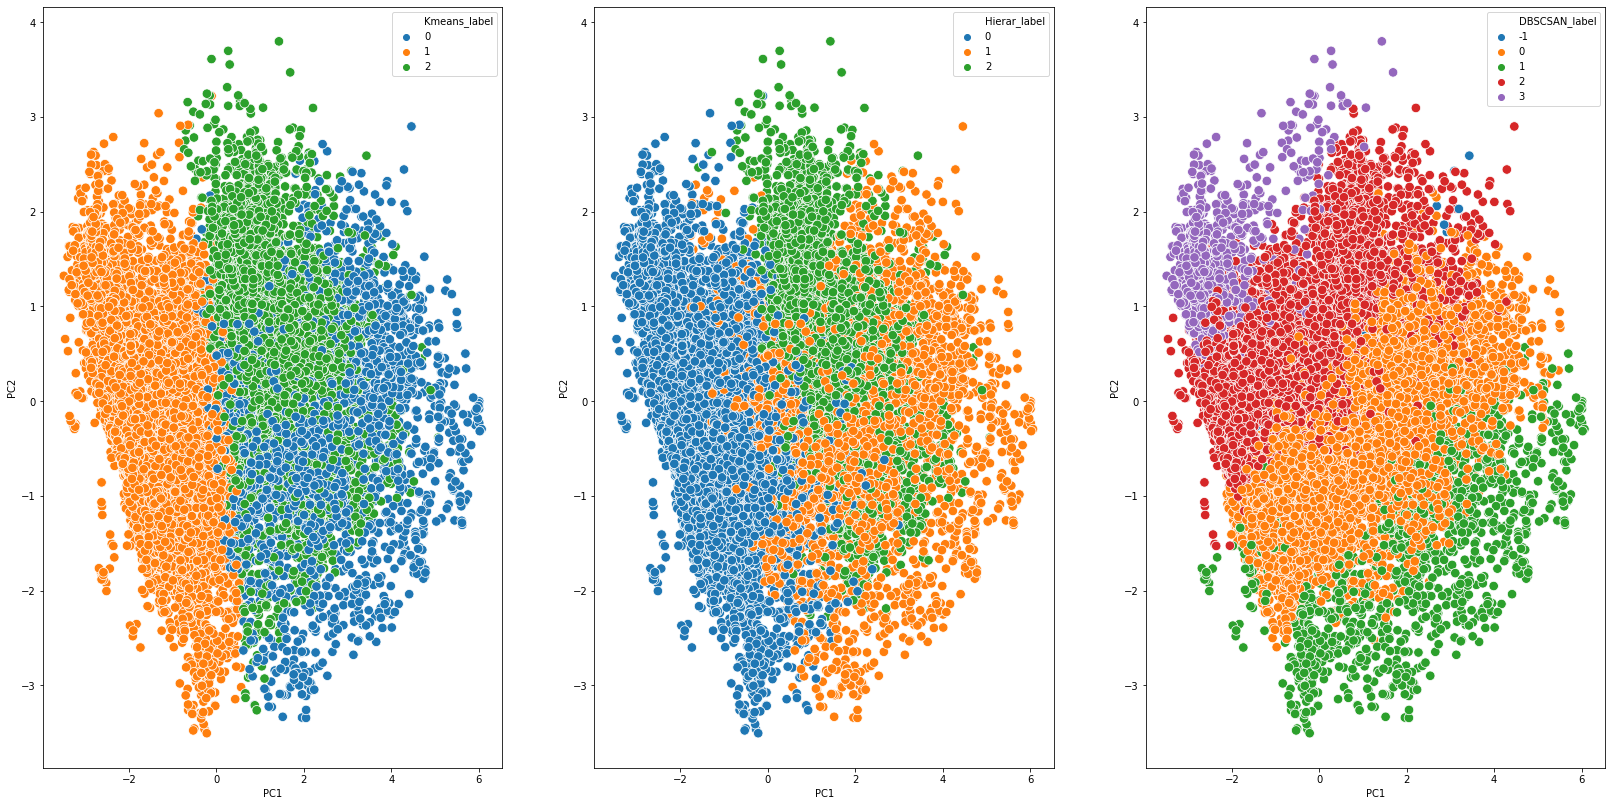

In [47]:

plt.figure(figsize = (28, 14))




plt.subplot(1,3,1)
sns.scatterplot(x = 'PC1', y = 'PC2', data = df_pca,  s = 90, hue = df_power['Kmeans_label'], palette = 'tab10')


plt.subplot(1,3,2)
sns.scatterplot(x = 'PC1', y = 'PC2', data = df_pca,  s = 90, hue = df_power['Hierar_label'], palette = 'tab10')



plt.subplot(1,3,3)
sns.scatterplot(x = 'PC1', y = 'PC2', data = df_pca,  s = 90, hue = df_power['DBSCSAN_label'], palette = 'tab10')


plt.show()

The subplots above represent clusters formed by different algorithms. We can see that the K-means and hierarchical clustering have created 3 clusters, while the DBSCAN algorithm has grouped the data into 4 clusters.<br><br> The plots for K-means and hierarchical clustering show similarity in cluster formation. The DBSCAN algorithm has clustered houses based on the power consumption of the other appliances in the house. Also, the blue points in the DBSCAN plot represent the outliers identified by the algorithm.<br><br> We can see that some points overlap in the subplots, this is because we have projected a 7-D dataset to 2-D which is explaining only 65 percent of total variance in the original data